# IXPLORE demo

This notebook demonstrates a compact workflow for using IXPLORE.

- Load example reaction data (binary or Likert-scale).
- Initialize and fit `IXPLORE` (with and without PCA initialization).
- Visualize the learned 2D embedding and decision boundaries for ssome questions.
- Embed a new user from partial answers and impute missing responses interpretably.
- Evaluate fit (MAE, accuracy) and examine model parameters.

Required packages: `numpy`, `pandas`, `scikit-learn`, `scipy`, `matplotlib`, and the local `ixplore` package (install with `pip install -e .`).


In [1]:
import numpy as np
import pandas as pd
from ixplore import IXPLORE
from ixplore.visualization import plot_overview, plot_posterior
from ixplore.utils import transformation_matrix

### Load data

This cell loads user metadata (for example colours or labels) used to annotate plots. Synthetic data was generated in notebooks/simulation.ipynb.

In [2]:
users = pd.read_csv('../data/synthetic_users.csv', index_col=0)
users

x      y  party color
id                            
0   -0.468 -0.583      0    C0
1   -0.244 -0.432      0    C0
2   -0.346 -0.412      0    C0
3   -0.514 -0.558      0    C0
4   -0.419 -0.586      0    C0
..     ...    ...    ...   ...
245 -0.154  0.210      4    C4
246  0.012 -0.171      4    C4
247 -0.079 -0.067      4    C4
248 -0.203  0.279      4    C4
249  0.270  0.024      4    C4

[250 rows x 4 columns]

This cell loads the user-item reaction matrix. For Likert data, IXPLORE automatically normalizes responses to the [0,1] range.

In [3]:
reactions = pd.read_csv('../data/likert_reactions.csv', index_col=0)
reactions

Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q31  Q32  Q33  Q34  Q35  \
id                                            ...                            
0     0   1   3   0   0   1   1   0   3    1  ...    3    3    2    3    3   
1     0   1   3   0   0   1   1   1   2    2  ...    3    3    2    2    3   
2     1   1   3   0   0   1   1   1   2    2  ...    3    3    2    3    3   
3     0   1   3   0   0   1   1   0   3    1  ...    3    3    2    3    3   
4     0   1   3   0   0   1   1   0   3    1  ...    3    3    2    3    3   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
245   2   3   1   0   1   1   0   3   2    3  ...    2    3    2    1    2   
246   1   2   2   0   0   1   0   3   1    3  ...    3    3    2    1    2   
247   1   2   2   0   0   1   0   3   2    3  ...    3    3    2    1    2   
248   2   3   1   0   1   0   0   3   2    3  ...    1    3    1    1    3   
249   1   3   2   0   1   1   0   3   1    3  ...    3    3    2    0    1   

     Q36  Q37  Q38  Q39  Q40  
id                            
0      0    0    1    3    0  
1      1    0    1    2    1  
2      0    0    1    3    1  
3      0    0    1    3    1  
4      0    0    1    3    0  
..   ...  ...  ...  ...  ...  
245    3    1    2    3    2  
246    3    0    1    2    1  
247    3    0    2    2    1  
248    3    1    3    3    3  
249    3    0    2    1    1  

[250 rows x 40 columns]

## Train models

### Random initialization

In [4]:
xplore = IXPLORE(reactions, pca_initialization=False, random_state=17)


2026-02-14 23:32:57,493 - ixplore - INFO - Number of users for model: 250
2026-02-14 23:32:57,493 - ixplore - INFO - Number of items: 40
2026-02-14 23:32:57,494 - ixplore - INFO - Number of missing values: 0 (0.00%)
2026-02-14 23:32:57,495 - ixplore - INFO - Grid created with resolution 200x200, total 40000 points
2026-02-14 23:32:57,498 - ixplore - INFO - Prior set with mean [0 0] and covariance [0.1 0.  0.  0.1]
2026-02-14 23:32:57,499 - ixplore - INFO - Random state set to 17
2026-02-14 23:32:57,499 - ixplore - INFO - Initialized embedding with random values.
2026-02-14 23:32:57,557 - ixplore - INFO - Fitted model parameters from embedding.


We initialize the user positions randomly (left panel) and learn logistic regression models based on these positions (righ panel).

2026-02-14 23:32:57,638 - ixplore - INFO - MAE: 0.2782182946600991, ACC: 0.6919


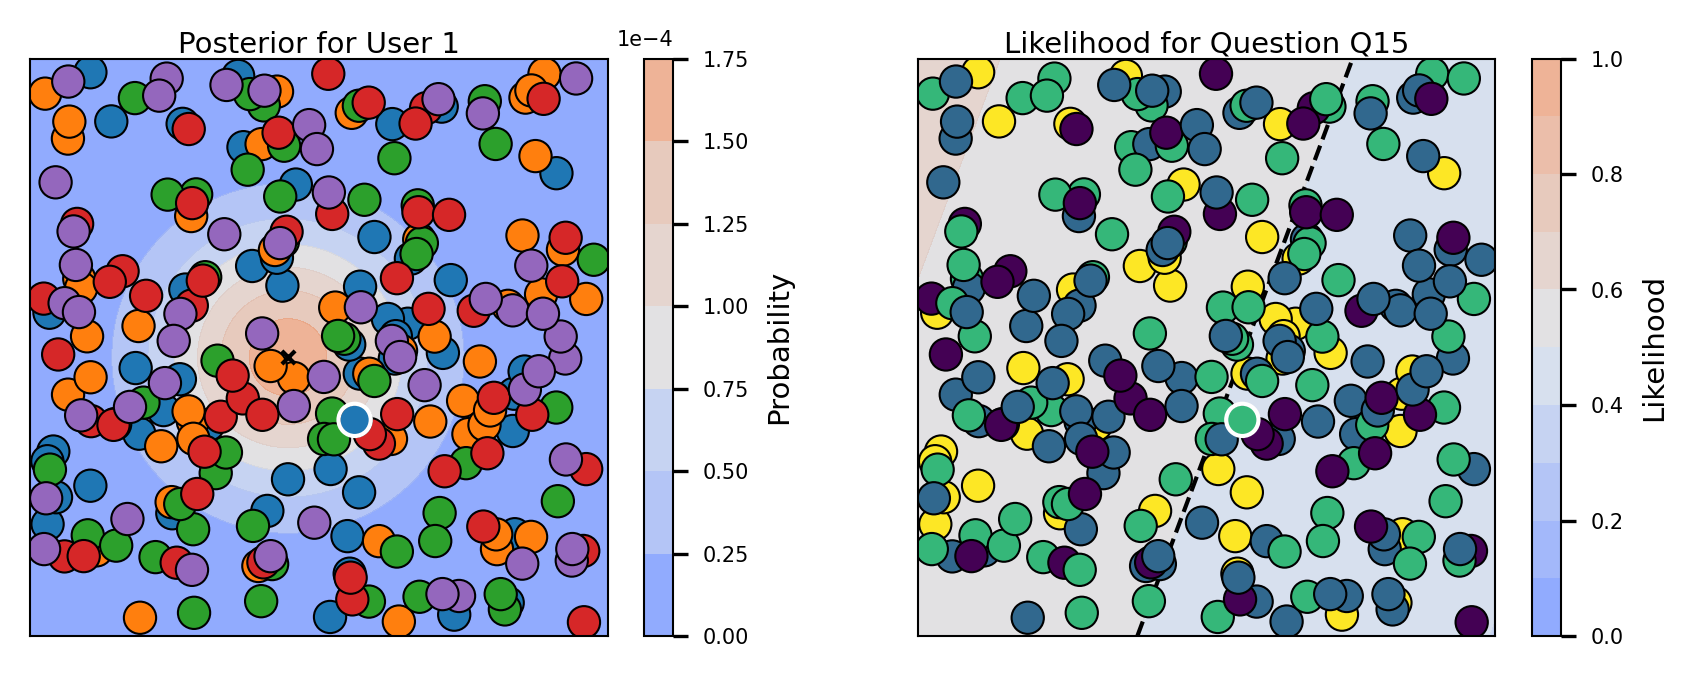

In [5]:
fig, (ax1, ax2) = plot_overview(xplore, question='Q15', user='1', colors=users.color, figsize=(7,2.5))

We fit posterior distributions for all users using the current logistic regression models, then visualize the posterior for one example user.

In [6]:
xplore.fit_posteriors()
fig, (ax1, ax2) = plot_overview(xplore, question='Q15', user='1', colors=users.color, figsize=(7,2.5))

2026-02-14 23:32:59,086 - ixplore - INFO - MAE: 0.27631426768637213, ACC: 0.6905


We center and scale the embedding so points fit within the defined plotting limits, then re-plot the overview.

In [7]:
xplore.normalize_embedding()
fig, (ax1, ax2) = plot_overview(xplore, question='Q15', user='1', colors=users.color, figsize=(7,2.5))

2026-02-14 23:32:59,310 - ixplore - INFO - MAE: 0.26651958778722257, ACC: 0.7205999999999999


We fit logistic regression models for each question using the current embedding as features. The decisions boundaries start to be meaningful (right panel). The new posterior distribution of the inspected user got slightly modifed (left panel).

2026-02-14 23:32:59,639 - ixplore - INFO - MAE: 0.09439345417523959, ACC: 0.9445


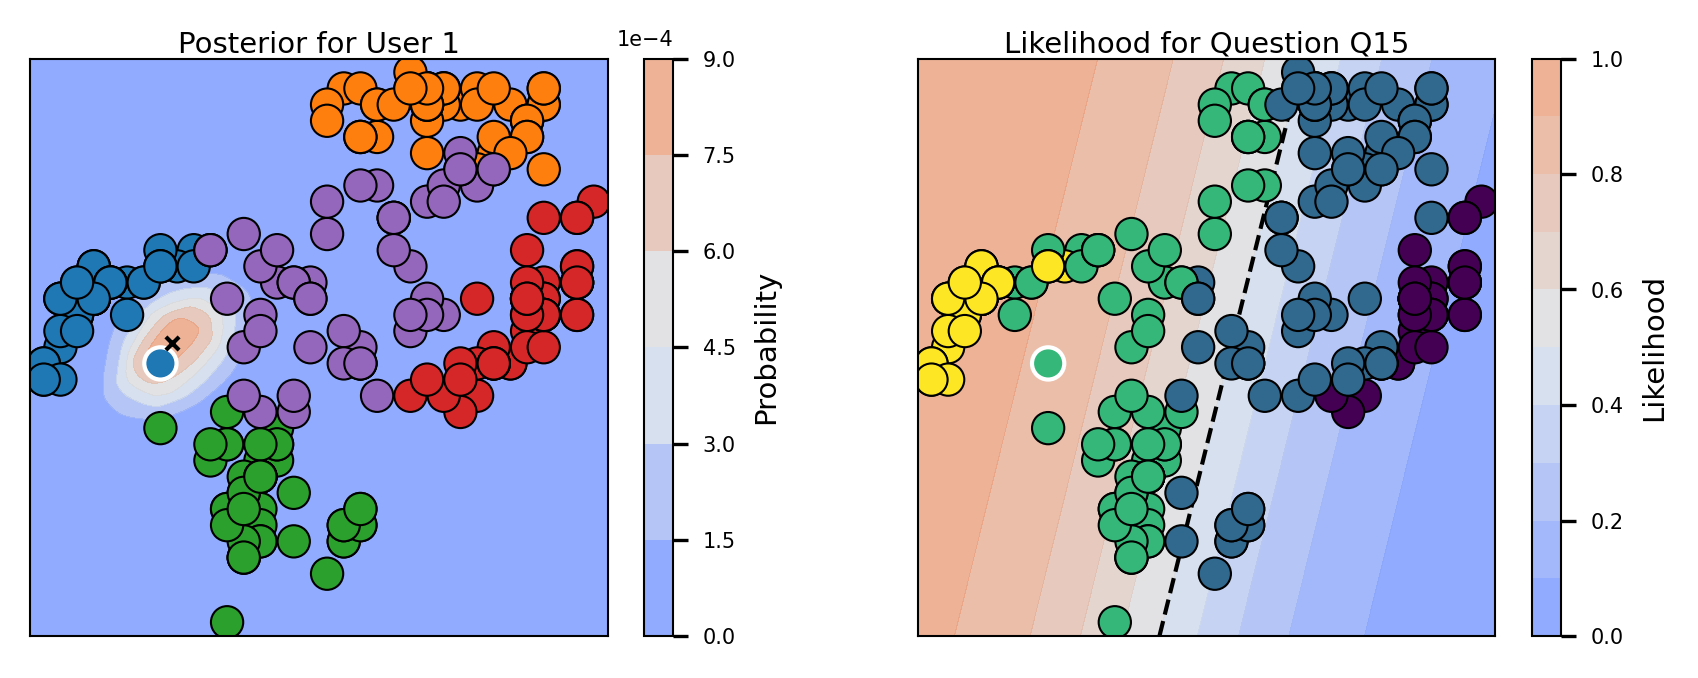

In [8]:
xplore.fit_models()
fig, (ax1, ax2) = plot_overview(xplore, question='Q15', user='1', colors=users.color, figsize=(7,2.5))

We repeat these three steps for another four iterations and see how the mean absolute error goes down.

2026-02-14 23:32:59,821 - ixplore - INFO - Iteration 1/4
2026-02-14 23:33:01,066 - ixplore - INFO - Fit MAE: 0.0797, Fit accuracy: 0.9695
2026-02-14 23:33:01,066 - ixplore - INFO - Iteration 2/4
2026-02-14 23:33:02,314 - ixplore - INFO - Fit MAE: 0.0795, Fit accuracy: 0.9717
2026-02-14 23:33:02,315 - ixplore - INFO - Iteration 3/4
2026-02-14 23:33:03,550 - ixplore - INFO - Fit MAE: 0.0799, Fit accuracy: 0.9722
2026-02-14 23:33:03,550 - ixplore - INFO - Iteration 4/4
2026-02-14 23:33:04,807 - ixplore - INFO - Fit MAE: 0.0802, Fit accuracy: 0.9684
2026-02-14 23:33:04,853 - ixplore - INFO - MAE: 0.08021454946072736, ACC: 0.9684


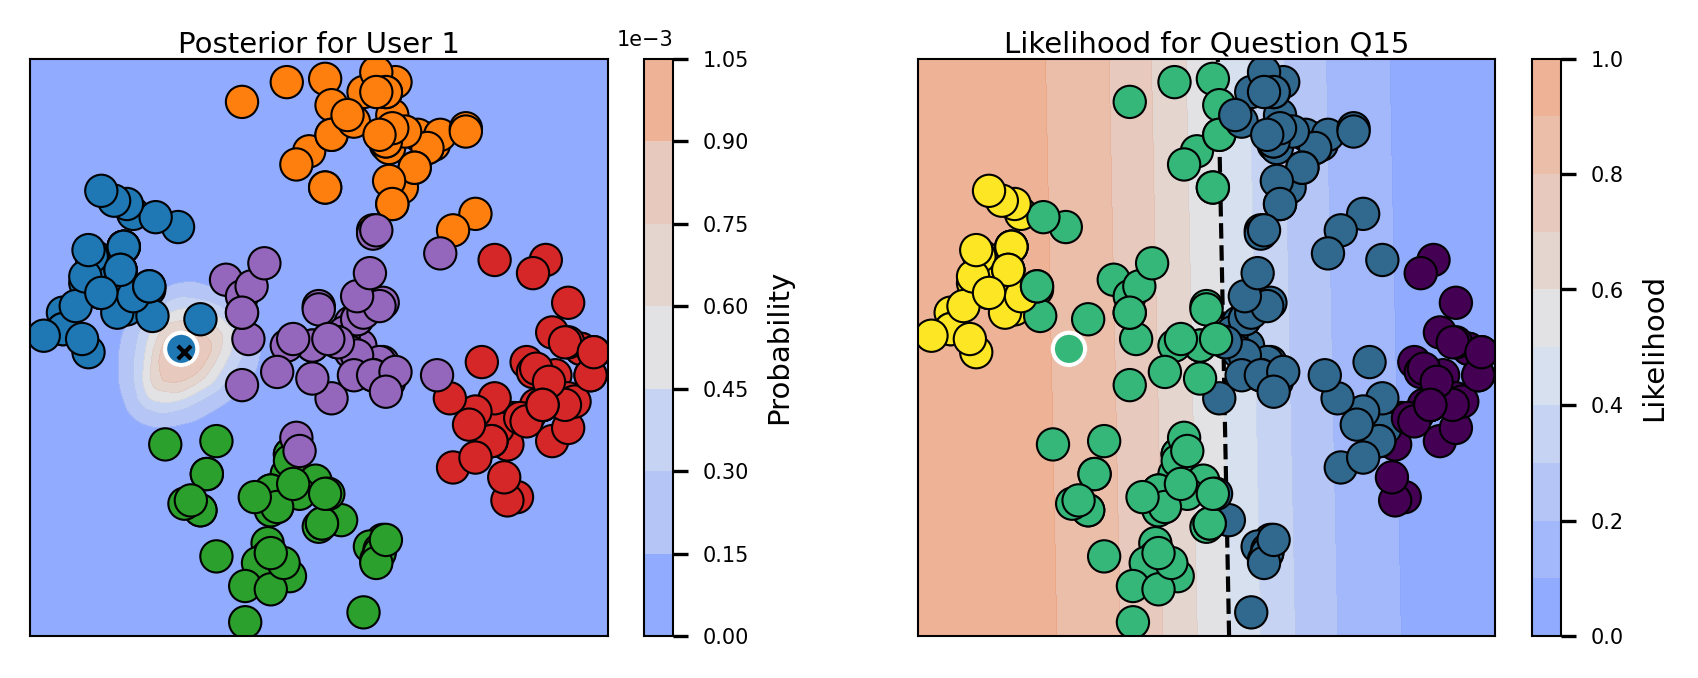

In [9]:
xplore.iterate(n_iterations=4)
fig, (ax1, ax2) = plot_overview(xplore, question='Q15', user='1', colors=users.color, figsize=(7,2.5))

We apply a linear transformation (rotation/shear/scale) to the embedding to align with typical dimensions in political landscapes.

In [10]:
M = transformation_matrix(rotation=55, scale=(1.1, 1), order=('shear', 'rotate', 'scale'))
xplore.transform_embedding(M)
fig, (ax1, ax2) = plot_overview(xplore, question='Q15', user='1', colors=users.color, figsize=(7,2.5))

2026-02-14 23:33:05,163 - ixplore - INFO - MAE: 0.07643187307566705, ACC: 0.9672


Let's update the posteriors one more time. to save this image for the README.

2026-02-14 23:33:06,566 - ixplore - INFO - MAE: 0.08685104381749531, ACC: 0.9499


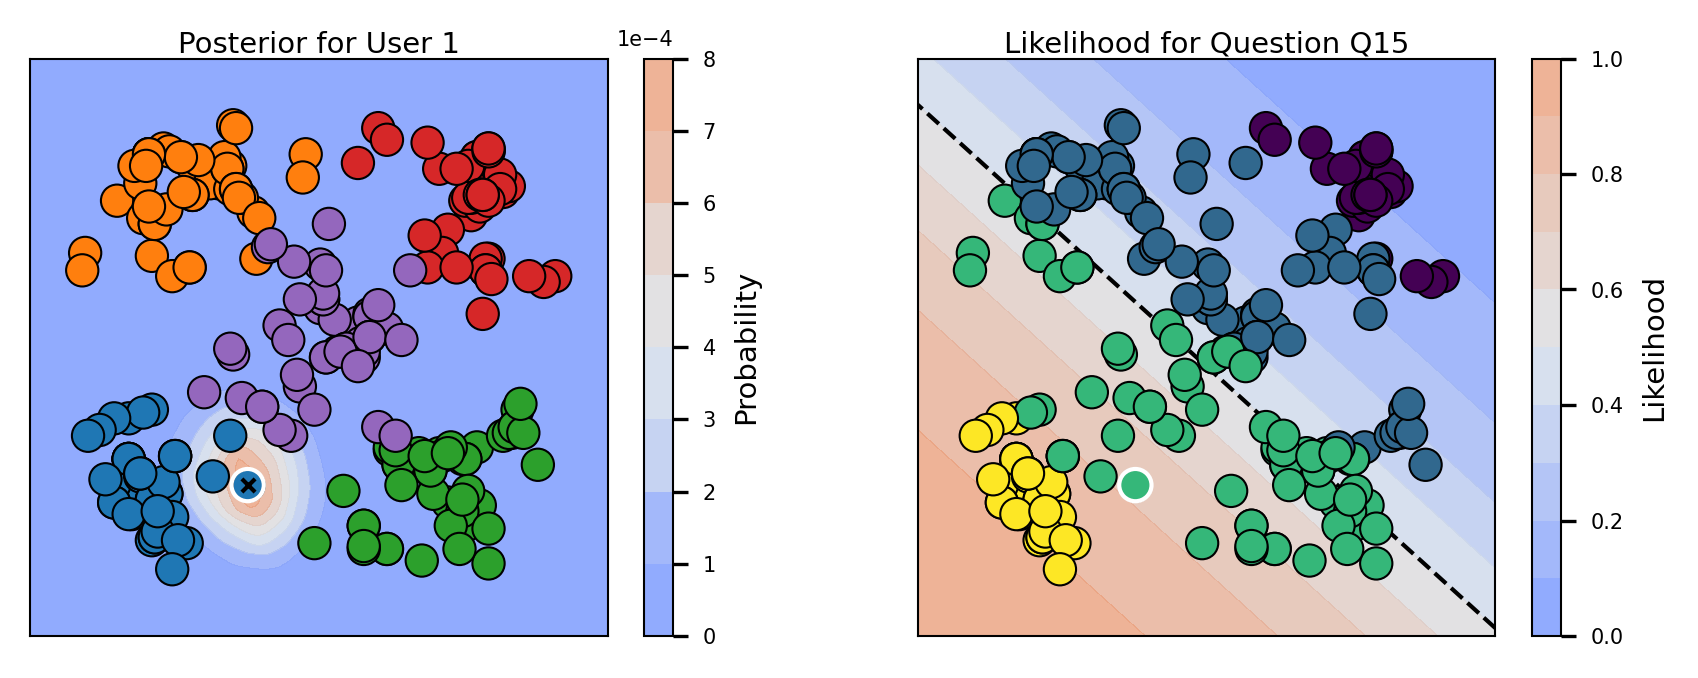

In [11]:
xplore.fit_posteriors()
fig, (ax1, ax2) = plot_overview(xplore, question='Q15', user='1', colors=users.color, figsize=(7,2.5))
fig.savefig("../docs/overview.png", dpi=300, bbox_inches="tight")

### Initialize with transformation

We can then later initialize the model directly with this predefined transformation matrix.

2026-02-14 23:33:06,896 - ixplore - INFO - Number of users for model: 250
2026-02-14 23:33:06,896 - ixplore - INFO - Number of items: 40
2026-02-14 23:33:06,897 - ixplore - INFO - Number of missing values: 0 (0.00%)
2026-02-14 23:33:06,899 - ixplore - INFO - Grid created with resolution 200x200, total 40000 points
2026-02-14 23:33:06,903 - ixplore - INFO - Prior set with mean [0 0] and covariance [0.1 0.  0.  0.1]
2026-02-14 23:33:06,903 - ixplore - INFO - Random state set to 17
2026-02-14 23:33:06,903 - ixplore - INFO - Initialized embedding with random values.
2026-02-14 23:33:06,964 - ixplore - INFO - Fitted model parameters from embedding.
2026-02-14 23:33:06,965 - ixplore - INFO - Iteration 1/5
2026-02-14 23:33:08,197 - ixplore - INFO - Fit MAE: 0.0885, Fit accuracy: 0.9489
2026-02-14 23:33:08,198 - ixplore - INFO - Iteration 2/5
2026-02-14 23:33:09,435 - ixplore - INFO - Fit MAE: 0.0753, Fit accuracy: 0.9722
2026-02-14 23:33:09,435 - ixplore - INFO - Iteration 3/5
2026-02-14 23:3

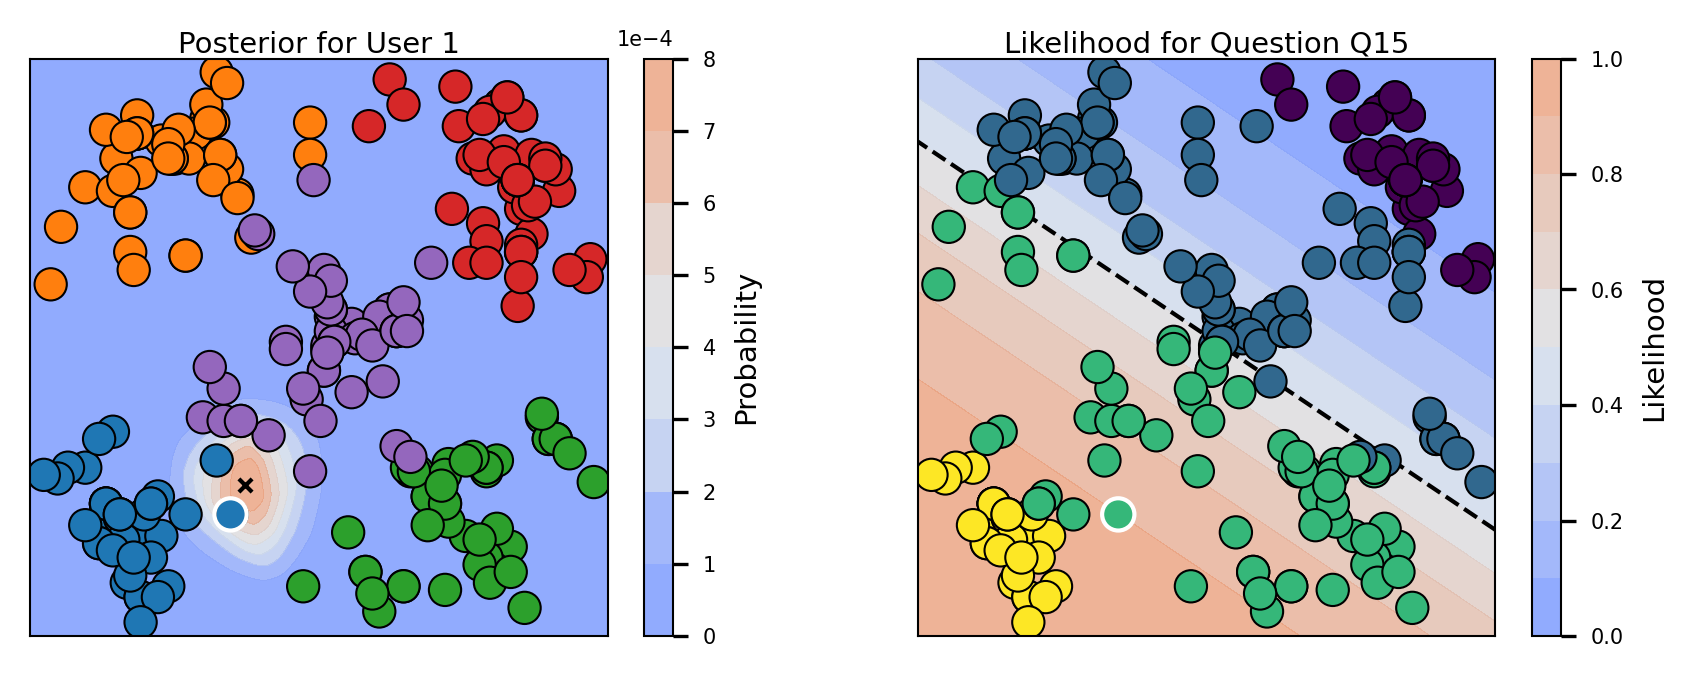

In [12]:
M = transformation_matrix(rotation=55, scale=(1.1, 1), order=('shear', 'rotate', 'scale'))

transformed_xplore = IXPLORE(reactions, pca_initialization=False, random_state=17, transformation=M)
transformed_xplore.iterate(n_iterations=5)
fig, (ax1, ax2) = plot_overview(transformed_xplore, question='Q15', user='1', colors=users.color, figsize=(7,2.5))

We can save the embedding coordinates and model parameters to load them directly later.

In [13]:
path = '../data/pretrained_embedding.csv'
transformed_xplore.get_embedding().to_csv(path)

path = '../data/pretrained_models.csv'
transformed_xplore.get_item_parameters().to_csv(path)

### Initialize with PCA

We can directly initialize the embedding with PCA to speed up the convergence.

2026-02-14 23:33:13,444 - ixplore - INFO - Number of users for model: 250
2026-02-14 23:33:13,445 - ixplore - INFO - Number of items: 40
2026-02-14 23:33:13,445 - ixplore - INFO - Number of missing values: 0 (0.00%)
2026-02-14 23:33:13,446 - ixplore - INFO - Grid created with resolution 200x200, total 40000 points
2026-02-14 23:33:13,449 - ixplore - INFO - Prior set with mean [0 0] and covariance [0.1 0.  0.  0.1]
2026-02-14 23:33:13,450 - ixplore - INFO - Random state set to 17
2026-02-14 23:33:13,453 - ixplore - INFO - Initialized embedding with PCA.
2026-02-14 23:33:13,519 - ixplore - INFO - Fitted model parameters from embedding.
2026-02-14 23:33:13,567 - ixplore - INFO - MAE: 0.07680515195865298, ACC: 0.9779


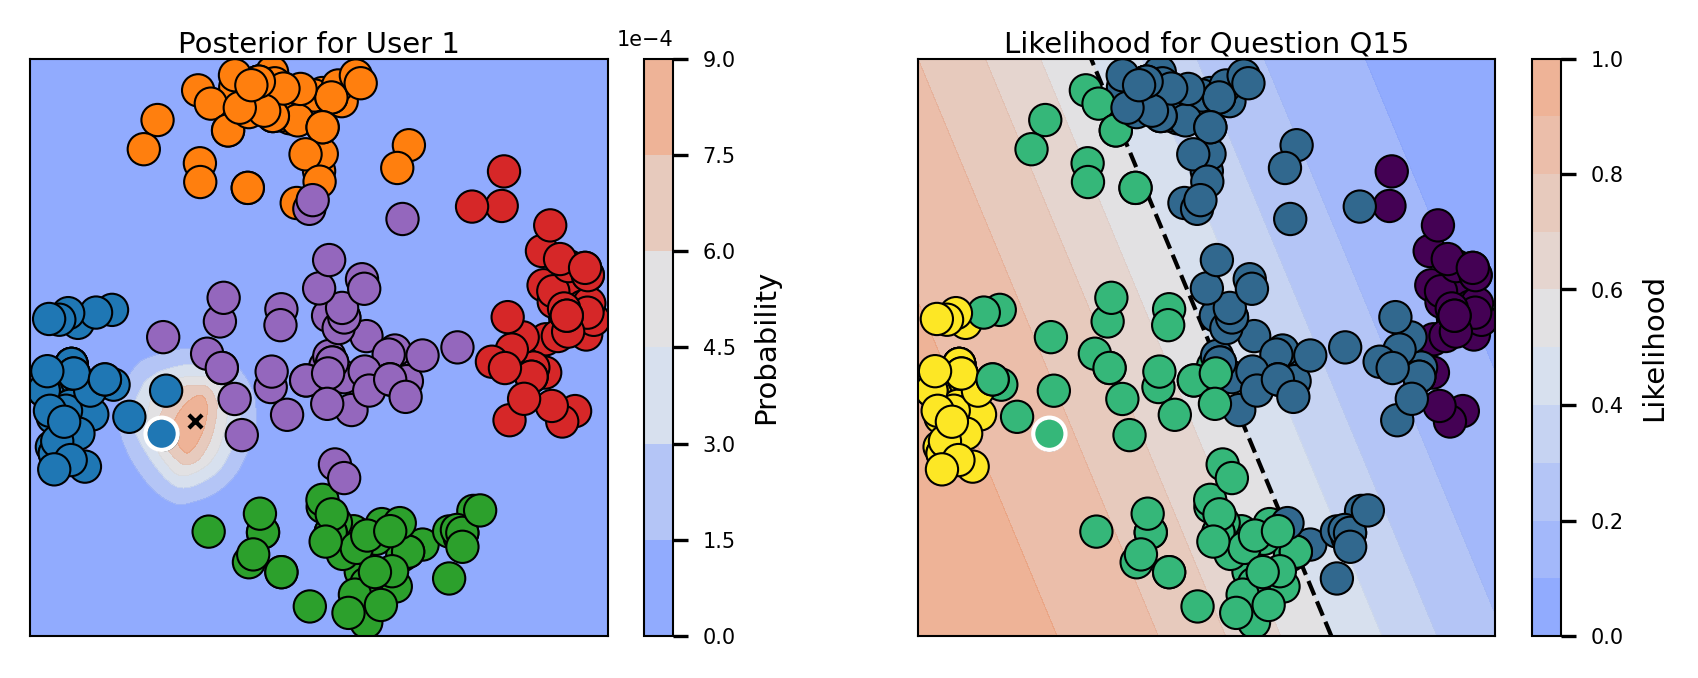

In [14]:
pca_xplore = IXPLORE(reactions, pca_initialization=True, random_state=17)
fig, (ax1, ax2) = plot_overview(pca_xplore, question='Q15', user='1', colors=users.color, figsize=(7,2.5))

## Load model

We can load a model with pretrained parameters.

2026-02-14 23:33:13,758 - ixplore - INFO - Number of users for model: 250
2026-02-14 23:33:13,758 - ixplore - INFO - Number of items: 40
2026-02-14 23:33:13,760 - ixplore - INFO - Number of missing values: 0 (0.00%)
2026-02-14 23:33:13,761 - ixplore - INFO - Grid created with resolution 200x200, total 40000 points
2026-02-14 23:33:13,763 - ixplore - INFO - Prior set with mean [0 0] and covariance [0.1 0.  0.  0.1]
2026-02-14 23:33:13,764 - ixplore - INFO - Random state set to 0
2026-02-14 23:33:13,765 - ixplore - INFO - Pretrained embedding loaded from ../data/pretrained_embedding.csv
2026-02-14 23:33:13,766 - ixplore - INFO - Used pretrained embedding.
2026-02-14 23:33:13,832 - ixplore - INFO - Fitted model parameters from embedding.
2026-02-14 23:33:13,860 - ixplore - INFO - MAE: 0.07751225248084485, ACC: 0.9638


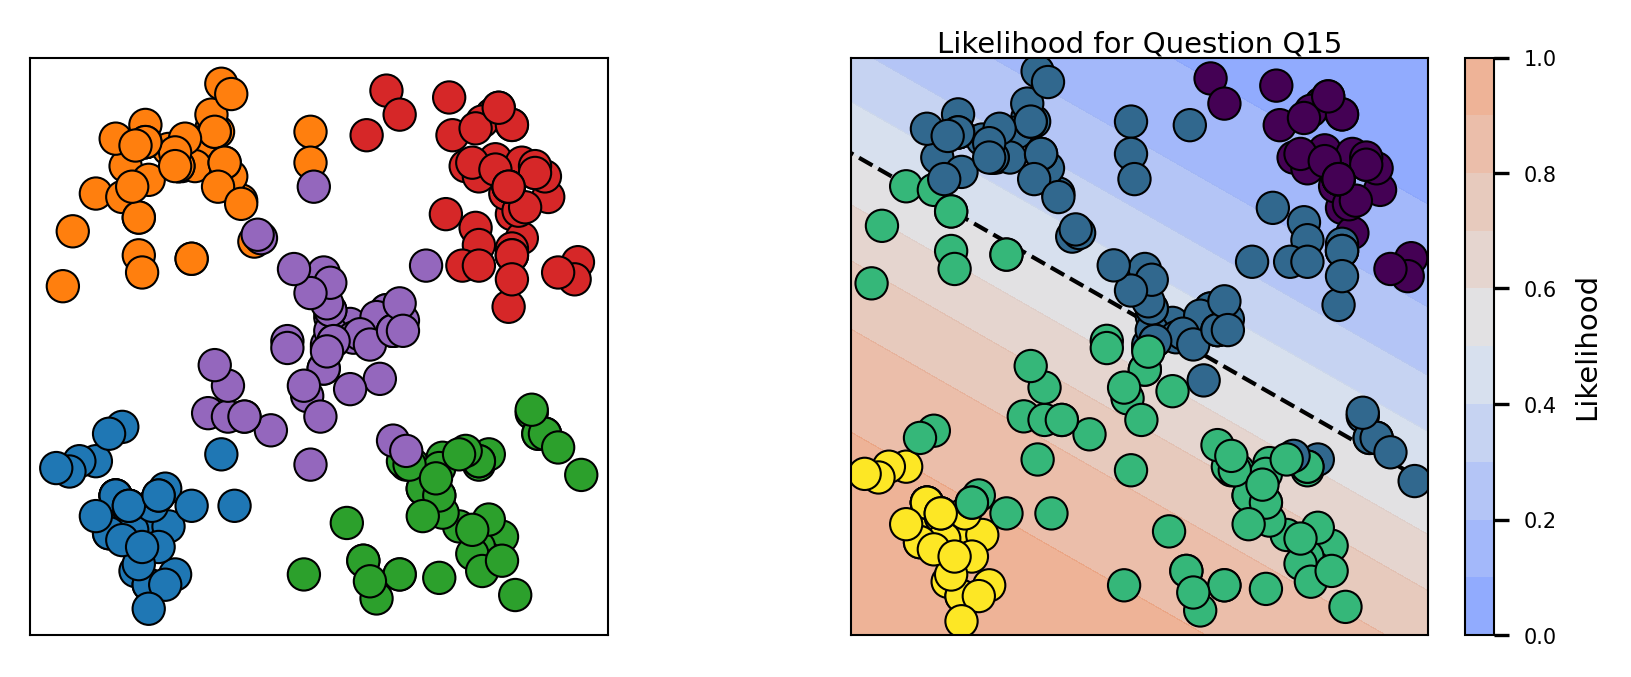

In [15]:
path = '../data/pretrained_embedding.csv'
loaded_xplore = IXPLORE(reactions, pretrained_embedding=path)
fig, (ax1, ax2) = plot_overview(loaded_xplore, question='Q15', user=None, colors=users.color, figsize=(7,2.5))

We can also embed a new user that has only answered one question and see where they would be located in the embedding space. 

In [16]:
new_user = pd.Series({'Q15':0}, name='new_user')
new_user

Q15    0
Name: new_user, dtype: int64

Because the prior distribution is very strong, this one answer doesn't have a high impact on the position.

2026-02-14 23:33:14,039 - ixplore - INFO - MAE: 0.07751225248084485, ACC: 0.9638


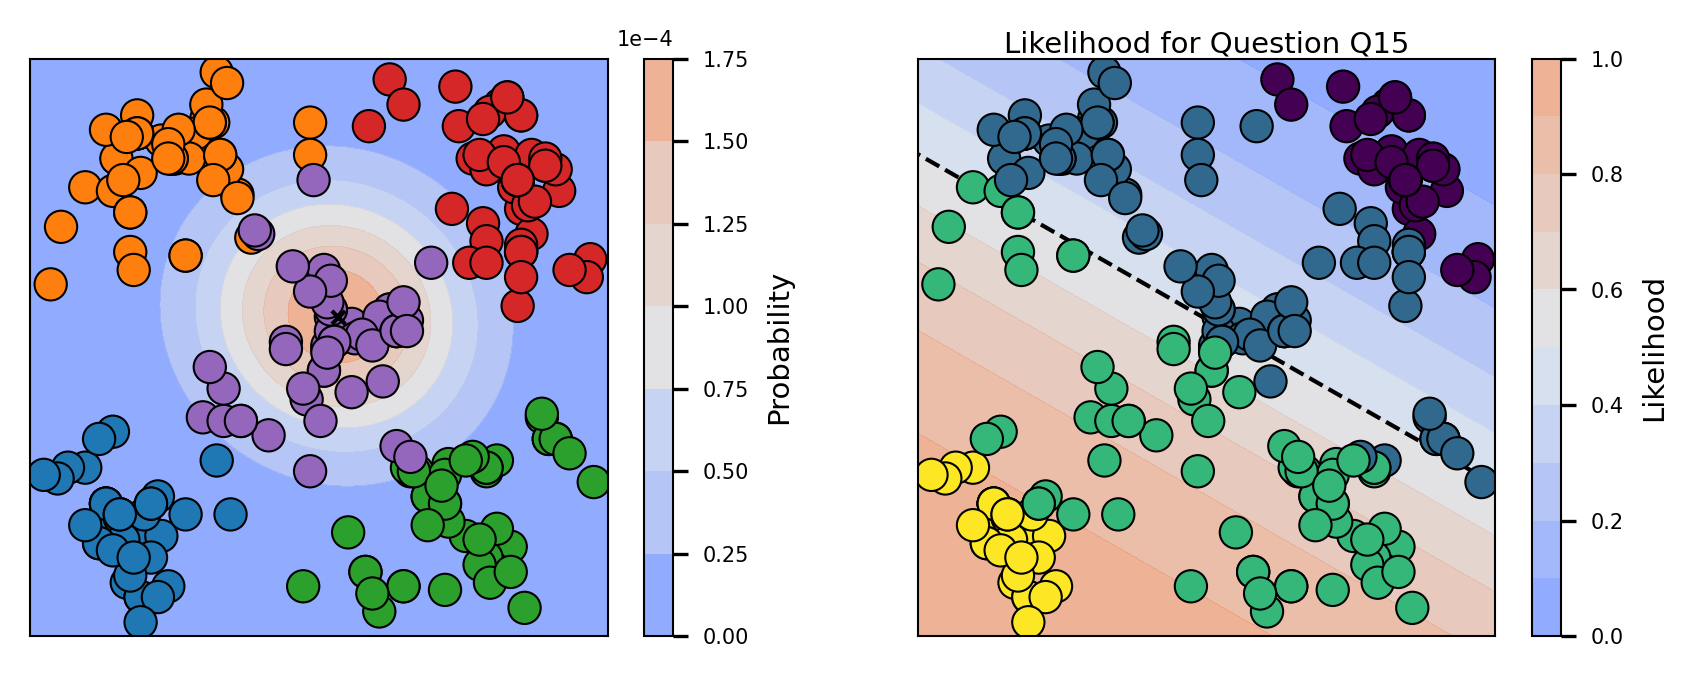

In [17]:
fig, (ax1, ax2) = plot_overview(loaded_xplore, question='Q15', user=None, colors=users.color, figsize=(7,2.5))
fig, ax1 = plot_posterior(loaded_xplore, new_user, ax=ax1) 

Let's say, we want to create a user that is at the very top left of the embedding space. We can then predict more answers for this position.

In [18]:
answers = loaded_xplore.predict(np.array([[-1,1]])).flatten().round()
new_user = pd.Series(answers, index=loaded_xplore.items, name='new_user')
new_user.head()

Q1    1.0
Q2    1.0
Q3    0.0
Q4    0.0
Q5    0.0
Name: new_user, dtype: float64

If we embed this user, we see that they end up in the area at the top left.

2026-02-14 23:33:14,266 - ixplore - INFO - MAE: 0.07751225248084485, ACC: 0.9638


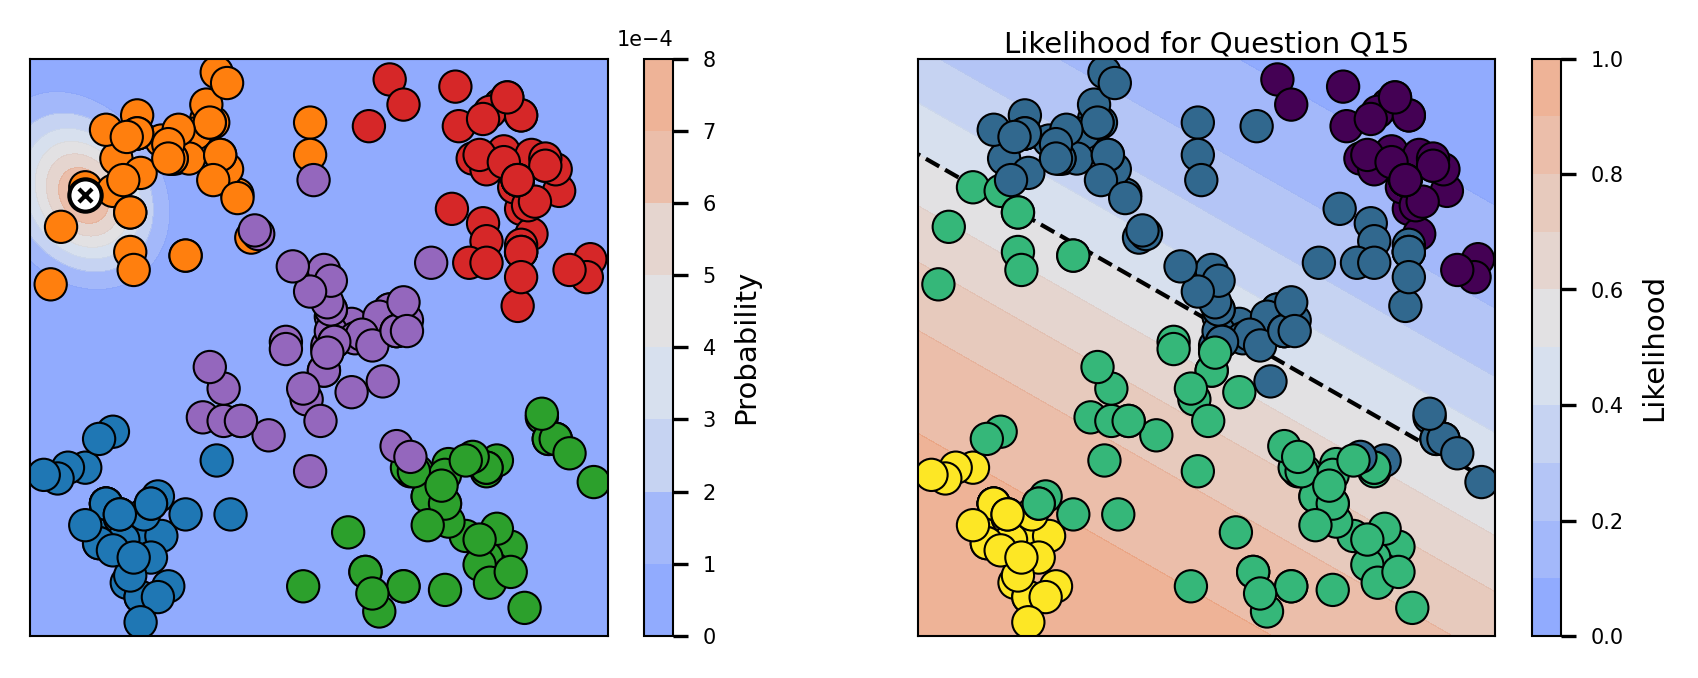

In [19]:
fig, (ax1, ax2) = plot_overview(loaded_xplore, question='Q15', user=None, colors=users.color, figsize=(7,2.5))
x, y = loaded_xplore.embed_new_user(new_user)
ax1.scatter(x, y, color='white', edgecolors='black', s=60, zorder=5)
fig, ax1 = plot_posterior(loaded_xplore, new_user, ax=ax1) 

If we want them to be even further, we have to reduce the prior.

In [20]:
loaded_xplore.set_prior(prior_mean=np.zeros(2), prior_cov=np.eye(2)*0.2)

2026-02-14 23:33:14,512 - ixplore - INFO - MAE: 0.07751225248084485, ACC: 0.9638


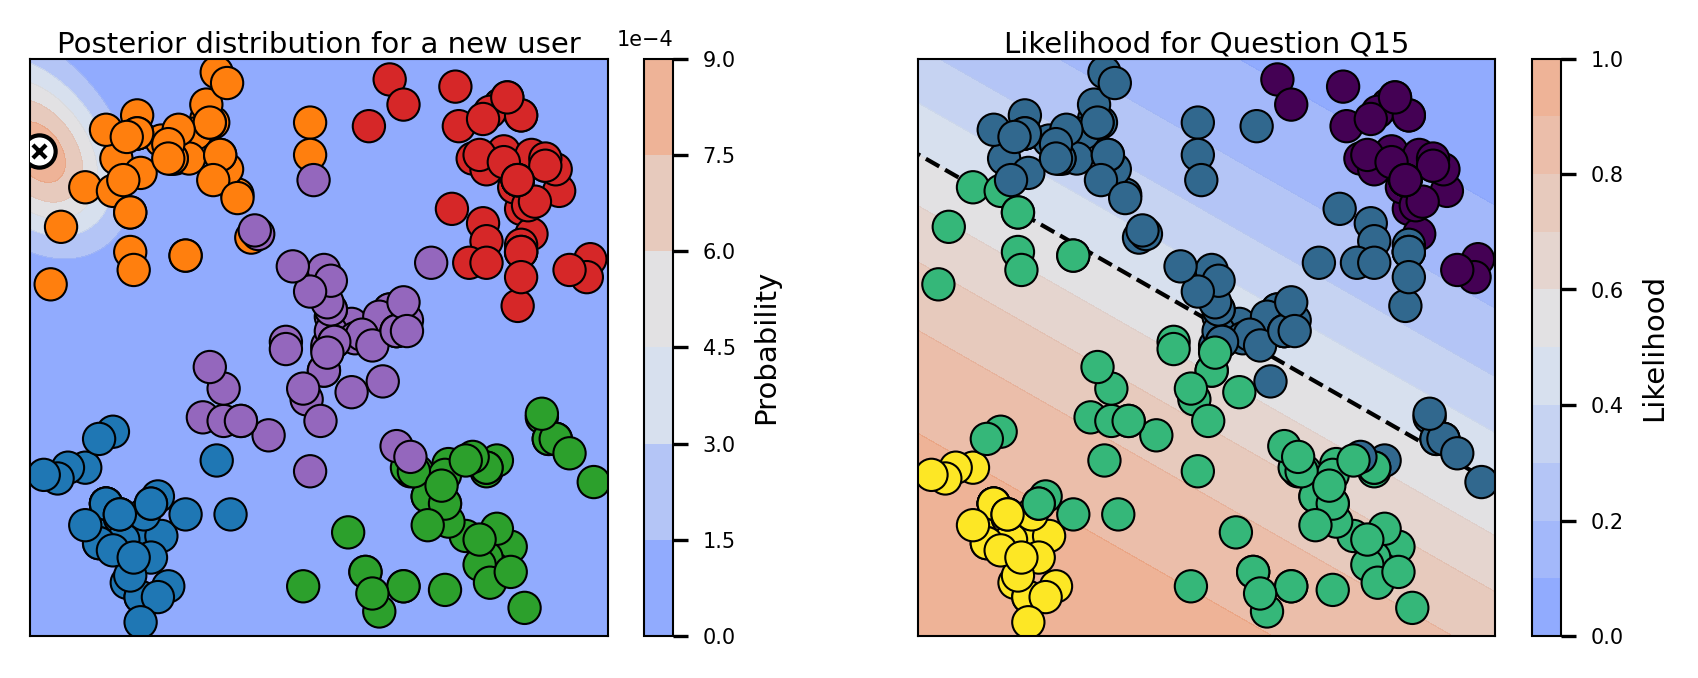

In [21]:
fig, (ax1, ax2) = plot_overview(loaded_xplore, question='Q15', user=None, colors=users.color, figsize=(7,2.5))
x, y = loaded_xplore.embed_new_user(new_user)
ax1.scatter(x, y, color='white', edgecolors='black', s=60, zorder=5)
fig, ax1 = plot_posterior(loaded_xplore, new_user, ax=ax1) 
ax1.set_title("Posterior distribution for a new user")
fig.savefig("../docs/overview_new_user.png", dpi=300, bbox_inches="tight")